In [1]:
%run ../../NoteBooks/HocParse.ipynb
# This sets data

Section soma has 21 points!
Section axon has 172 points!
Section dend has 17 points!
	 132 more sections...


Starting...
Message recieved:  {'message': 'LOAD_EXAMPLE', 'data': {}}
Message recieved:  {'message': 'RENDER', 'data': {}}
Render!


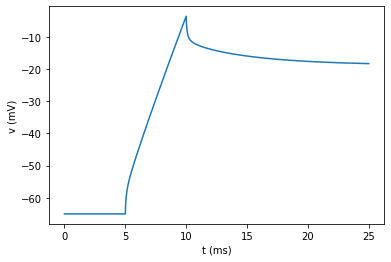

[0.0, 0.025, 0.05, 0.075, 0.09999999999999999, 0.12499999999999999, 0.15, 0.17500000000000002, 0.20000000000000004, 0.22500000000000006, 0.25000000000000006, 0.2750000000000001, 0.3000000000000001, 0.3250000000000001, 0.35000000000000014, 0.37500000000000017, 0.4000000000000002, 0.4250000000000002, 0.45000000000000023, 0.47500000000000026, 0.5000000000000002, 0.5250000000000001, 0.55, 0.575, 0.5999999999999999, 0.6249999999999998, 0.6499999999999997, 0.6749999999999996, 0.6999999999999995, 0.7249999999999994, 0.7499999999999993, 0.7749999999999992, 0.7999999999999992, 0.8249999999999991, 0.849999999999999, 0.8749999999999989, 0.8999999999999988, 0.9249999999999987, 0.9499999999999986, 0.9749999999999985, 0.9999999999999984, 1.0249999999999984, 1.0499999999999983, 1.0749999999999982, 1.099999999999998, 1.124999999999998, 1.149999999999998, 1.1749999999999978, 1.1999999999999977, 1.2249999999999976, 1.2499999999999976, 1.2749999999999975, 1.2999999999999974, 1.3249999999999973, 1.3499999

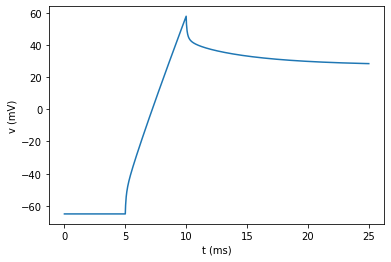

[0.0, 0.025, 0.05, 0.075, 0.09999999999999999, 0.12499999999999999, 0.15, 0.17500000000000002, 0.20000000000000004, 0.22500000000000006, 0.25000000000000006, 0.2750000000000001, 0.3000000000000001, 0.3250000000000001, 0.35000000000000014, 0.37500000000000017, 0.4000000000000002, 0.4250000000000002, 0.45000000000000023, 0.47500000000000026, 0.5000000000000002, 0.5250000000000001, 0.55, 0.575, 0.5999999999999999, 0.6249999999999998, 0.6499999999999997, 0.6749999999999996, 0.6999999999999995, 0.7249999999999994, 0.7499999999999993, 0.7749999999999992, 0.7999999999999992, 0.8249999999999991, 0.849999999999999, 0.8749999999999989, 0.8999999999999988, 0.9249999999999987, 0.9499999999999986, 0.9749999999999985, 0.9999999999999984, 1.0249999999999984, 1.0499999999999983, 1.0749999999999982, 1.099999999999998, 1.124999999999998, 1.149999999999998, 1.1749999999999978, 1.1999999999999977, 1.2249999999999976, 1.2499999999999976, 1.2749999999999975, 1.2999999999999974, 1.3249999999999973, 1.3499999

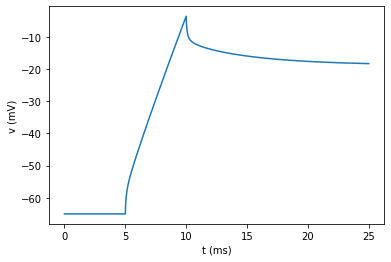

[0.0, 0.025, 0.05, 0.075, 0.09999999999999999, 0.12499999999999999, 0.15, 0.17500000000000002, 0.20000000000000004, 0.22500000000000006, 0.25000000000000006, 0.2750000000000001, 0.3000000000000001, 0.3250000000000001, 0.35000000000000014, 0.37500000000000017, 0.4000000000000002, 0.4250000000000002, 0.45000000000000023, 0.47500000000000026, 0.5000000000000002, 0.5250000000000001, 0.55, 0.575, 0.5999999999999999, 0.6249999999999998, 0.6499999999999997, 0.6749999999999996, 0.6999999999999995, 0.7249999999999994, 0.7499999999999993, 0.7749999999999992, 0.7999999999999992, 0.8249999999999991, 0.849999999999999, 0.8749999999999989, 0.8999999999999988, 0.9249999999999987, 0.9499999999999986, 0.9749999999999985, 0.9999999999999984, 1.0249999999999984, 1.0499999999999983, 1.0749999999999982, 1.099999999999998, 1.124999999999998, 1.149999999999998, 1.1749999999999978, 1.1999999999999977, 1.2249999999999976, 1.2499999999999976, 1.2749999999999975, 1.2999999999999974, 1.3249999999999973, 1.3499999

In [2]:
import asyncio
import websockets
import json

from neuron import h
from neuron.units import ms, mV

async def message_loop(websocket):
    while True:
        try:
            data = await websocket.recv()
            data = json.loads(data)

            print("Message recieved: ", data)
            
            request_type = data["message"]
            match request_type:
                case "LOAD_EXAMPLE":
                    await load_example(websocket)

                case "RENDER":
                    await render(websocket, data.data)
                    pass

        except websockets.exceptions.ConnectionClosedOK: 
            continue
        except json.decoder.JSONDecodeError:
            print("Invalid message:", data)
            break
        except Exception as e:
            print("Unkown error:", e)
       
async def load_example(socket):
    await socket.send(json.dumps([json.dumps( {"message" : "EXAMPLE_DATA", "segments": example_data } )]))

async def render(socket, data):
    print("Render!")

    for sec in h.allsec():
        h.delete_section(sec=sec)

    h.load_file('C:/Users/Jacob/Neuron-Web-Interface/Data/DeitcherEtAl2017/Morphs_and_trees/1148.hoc')
    h.load_file('stdrun.hoc')

    print(data)

    stim = h.IClamp(h.soma(0))
    stim.delay = 3
    stim.dur = 1
    stim.amp = 0.1

    v = h.Vector().record(h.soma(0.5)._ref_v).to_python()
    t = h.Vector().record(h._ref_t).to_python()

    h.finitialize(-65 * mV)
    h.continuerun(25 * ms)

    pass

async def main():
    async with websockets.serve(message_loop, "", 8001):
        await asyncio.Future()

print("Starting...")
await main()